In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,RepeatVector,TimeDistributed,Bidirectional
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
from scipy.stats import mannwhitneyu
import scipy

In [ ]:
# I used Google Chrome whilst working in Google Colab so I was able to complete this step by recieving the authorisation code after logging into my gmail account.
# Users may need to also use Google Chrome to run this code and connect via the browser to your gmail when prompted.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [ ]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [ ]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [ ]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [ ]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [ ]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [ ]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [ ]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [ ]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [ ]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [ ]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Split dataset into training and testing datasets

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I no longer need to create a validation set as model selection is complete 
#### 74.15% of the data will be used for training and the remaining 25.85% will be used as the test set

In [ ]:
split = int(len(df)*0.7415)

training_set = df[:split]      # 17/8/2017 - 28/6/2020
test_set = df[split:]          # 29/6/2020 - 28/6/2021

In [ ]:
print('Training: ', training_set.shape, '\nTest: ', test_set.shape)

Training:  (1046, 5) 
Test:  (366, 5)


# Split the data into X and y variables

In [ ]:
X_training = (training_set.iloc[:, :]).values.reshape(training_set.shape[0],training_set.shape[1])
y_training = (training_set.iloc[:, 4]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_testing = (test_set.iloc[:, :]).values.reshape(test_set.shape[0],test_set.shape[1])
y_testing = (test_set.iloc[:, 4]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)


(1046, 5) (1046, 1)
(366, 5) (366, 1)


# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler to do this

In [ ]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM

In [ ]:
# stack the data horizontally

train_stacked = np.hstack((X_train, y_train))
print ("Stacked Training Data Shape: " , train_stacked.shape)

test_stacked = np.hstack((X_test, y_test))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (1046, 6)
Stacked Test Data Shape:  (366, 6)


In [ ]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [ ]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 7

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (1027, 14, 5) y train sequences (1027, 7)
X test sequences:  (347, 14, 5) y test sequences (347, 7)


## Since I am going to be using LTC prices as the input for this model, I need to load the LTC dataset and carry out the same pre-processing steps as above on the LTC data.

Load the dataset

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving ltc_data.csv to ltc_data.csv


In [ ]:
ltc_data = pd.read_csv(io.BytesIO(uploaded['ltc_data.csv']), header=None)

In [ ]:
ltc_data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (LTC)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (LTC)', 'Buy Quote Volume (USDT)', 'Ignore']

Preprocessing steps

In [ ]:
ltc_data['Open Date'] = pd.to_datetime(ltc_data['Open Time'], unit='ms')
ltc_data['Close Date'] = pd.to_datetime(ltc_data['Close Time'], unit='ms')

In [ ]:
ltc_data['Close Date'] = ltc_data['Close Date'].dt.normalize()

In [ ]:
ltc_data.drop(['Open Time', 'Close Time', 'Ignore', 'Volume (LTC)', 'No. of trades', 'Buy Base Volume (LTC)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [ ]:
ltc_data.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [ ]:
ltc_data.set_index('Close Date', inplace=True)
ltc_data.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-12-13,272.00,330.00,260.00,290.01,2.770877e+06
2017-12-14,290.01,302.72,252.00,272.40,2.666481e+06
2017-12-15,272.40,314.21,239.99,294.00,4.658824e+06
2017-12-16,294.00,305.00,285.00,293.97,2.674492e+06
2017-12-17,293.01,328.80,290.00,311.40,4.618547e+06


In [ ]:
columns = ltc_data.columns.tolist()
columns = columns[-1:] + columns[:-1]
ltc_data = ltc_data[columns]

In [ ]:
ltc_data.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-12-13,2.770877e+06,272.00,330.00,260.00,290.01
2017-12-14,2.666481e+06,290.01,302.72,252.00,272.40
2017-12-15,4.658824e+06,272.40,314.21,239.99,294.00
2017-12-16,2.674492e+06,294.00,305.00,285.00,293.97
2017-12-17,4.618547e+06,293.01,328.80,290.00,311.40


In [ ]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [ ]:
ltc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2017-12-13 to 2021-08-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1344 non-null   float64
 1   Open    1344 non-null   float64
 2   High    1344 non-null   float64
 3   Low     1344 non-null   float64
 4   Close   1344 non-null   float64
dtypes: float64(5)
memory usage: 63.0 KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


I have fewer samples in the LTC dataset however I will still be able to create a training set that is the same proportion as the ETH training set.

Visualise the data

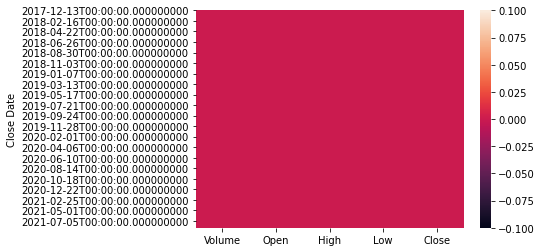

In [ ]:
sns.heatmap(ltc_data.isnull())  

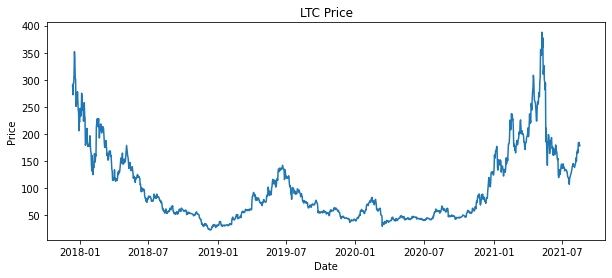

In [ ]:
plt.figure(figsize=(10,4)) 
plt.plot(ltc_data['Close'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LTC Price")
plt.xlim=["2017-11-10", "2021-07-10"]

[Text(0, 0.5, 'Volume'),
 (17480.0, 18818.0),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Trading Volume for LTC')]

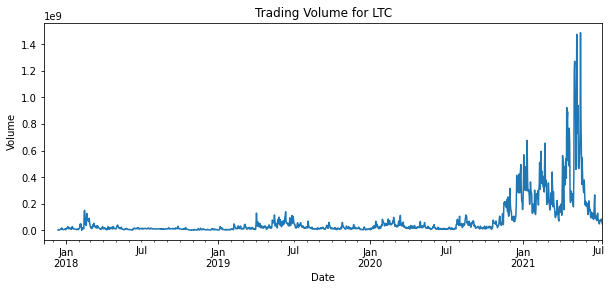

In [ ]:
plt.figure(figsize=(10,4)) 
ax = ltc_data.groupby(['Close Date'])['Volume'].mean().plot()
ax.set(xlabel="Date",
       ylabel="Volume",
       title="Trading Volume for LTC",
       xlim=["2017-11-10", "2021-07-10"])

Split the data into the same sized sets as the ETH data

In [ ]:
ltc_split = int(len(ltc_data)*0.7415)

ltc_training_set = ltc_data[:ltc_split]      # 17/8/2017 - 28/6/2020
ltc_test_set = ltc_data[ltc_split:]          # 29/6/2020 - 28/6/2021
     

In [ ]:
print('LTC Training: ', ltc_training_set.shape, '\nLTC Test: ', ltc_test_set.shape)

LTC Training:  (996, 5) 
LTC Test:  (348, 5)


In [ ]:
ltc_X_training = (ltc_training_set.iloc[:, :]).values.reshape(ltc_training_set.shape[0],ltc_training_set.shape[1])
ltc_y_training = (ltc_training_set.iloc[:, 4]).values.reshape(ltc_training_set.shape[0],1)

print(ltc_X_training.shape, ltc_y_training.shape)

ltc_X_testing = (ltc_test_set.iloc[:, :]).values.reshape(ltc_test_set.shape[0],ltc_test_set.shape[1])
ltc_y_testing = (ltc_test_set.iloc[:, 4]).values.reshape(ltc_test_set.shape[0],1)

print(ltc_X_testing.shape, ltc_y_testing.shape)

(996, 5) (996, 1)
(348, 5) (348, 1)


Normalisation

In [ ]:
ltc_Xscaler = MinMaxScaler(feature_range=(0,1))
ltc_yscaler = MinMaxScaler(feature_range=(0,1))

ltc_X_train = ltc_Xscaler.fit_transform(ltc_X_training)
ltc_y_train = ltc_yscaler.fit_transform(ltc_y_training)

ltc_X_test = ltc_Xscaler.fit_transform(ltc_X_testing)
ltc_y_test = ltc_yscaler.fit_transform(ltc_y_testing)

Preparing the sequences for multistep LSTM

In [ ]:
# stack the data horizontally

ltc_train_stacked = np.hstack((ltc_X_train, ltc_y_train))
print ("Stacked LTC Training Data Shape: " , ltc_train_stacked.shape)

ltc_test_stacked = np.hstack((ltc_X_test, ltc_y_test))
print ("Stacked LTC Test Data Shape: " , ltc_test_stacked.shape)

Stacked LTC Training Data Shape:  (996, 6)
Stacked LTC Test Data Shape:  (348, 6)


In [ ]:
# choose a number of time steps 
#n_steps_in, n_steps_out = 14, 7    # same timesteps as ETH

# run function
ltc_X_train, ltc_y_train = create_sequences(ltc_train_stacked, n_steps_in, n_steps_out)
print ("LTC X train sequences: " , ltc_X_train.shape, "LTC y train sequences" , ltc_y_train.shape)            

ltc_X_test, ltc_y_test = create_sequences(ltc_test_stacked, n_steps_in, n_steps_out)
print ("LTC X test sequences: " , ltc_X_test.shape, "LTC y test sequences" , ltc_y_test.shape)    

LTC X train sequences:  (977, 14, 5) LTC y train sequences (977, 7)
LTC X test sequences:  (329, 14, 5) LTC y test sequences (329, 7)


# **1. Model Building on CoLab for Multi-Step LSTM model (labelled in the code as Model A)**


#### I will now create an LSTM model with the same optimal parameters and architecture discovered from hypertuning. This model will be trained on the additional input data.


In [ ]:
n_features = X_train.shape[2]

rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

new_model_a = Sequential()
new_model_a.add(LSTM(units=80, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
new_model_a.add(LSTM(units=80, activation='relu', return_sequences=True))
new_model_a.add(Dropout(0.3))
new_model_a.add(LSTM(units=80, activation='relu'))
new_model_a.add(Dropout(0.3))
new_model_a.add(Dense(n_steps_out))
new_model_a.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate= 0.001) , metrics=[rmse, mae])

In [ ]:
new_model_a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 80)            27520     
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 80)            51520     
_________________________________________________________________
dropout (Dropout)            (None, 14, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 567       
Total params: 131,127
Trainable params: 131,127
Non-trainable params: 0
__________________________________________________

#### Train the model with the optimal parameters using LTC data as input and test it on the test set 5 times to predict ETH close prices.
https://github.com/yanghaocsg/keras_lstm/wiki/chapter-7.1-Evaluating-LSTM-Models-Robustly


Training Number  0


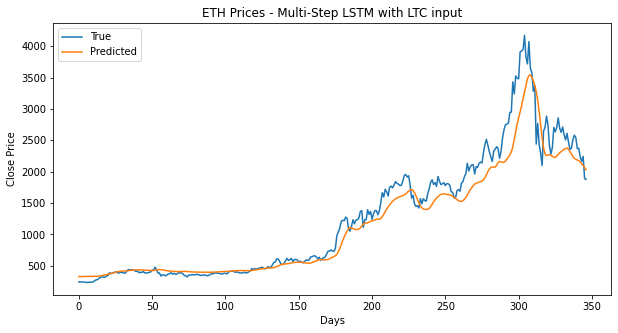


Testing Loss:  0.007  ||  Testing RMSE:  0.0836  ||  Testing MAE:  0.052

Training Number  1


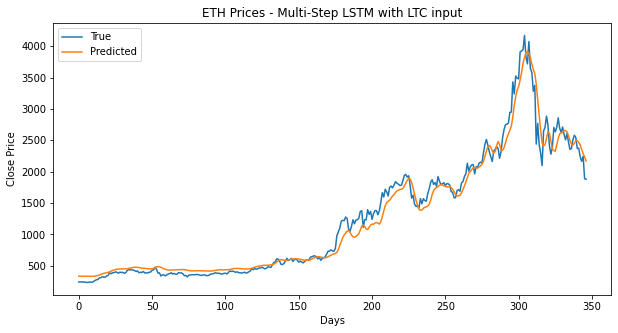


Testing Loss:  0.00416  ||  Testing RMSE:  0.0645  ||  Testing MAE:  0.0411

Training Number  2


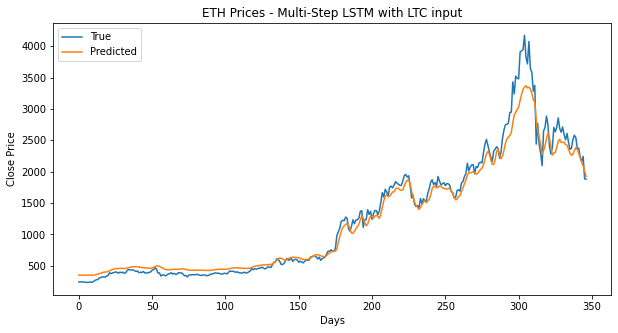


Testing Loss:  0.00405  ||  Testing RMSE:  0.0637  ||  Testing MAE:  0.0403

Training Number  3


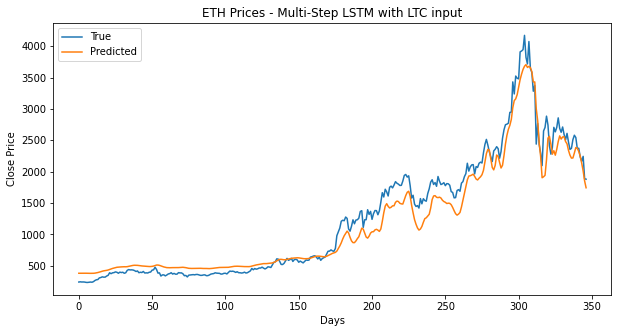


Testing Loss:  0.00608  ||  Testing RMSE:  0.078  ||  Testing MAE:  0.0563

Training Number  4


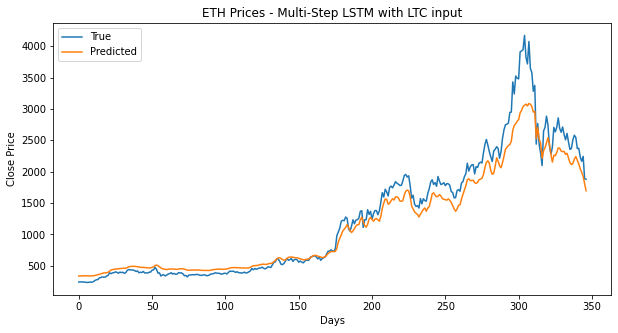


Testing Loss:  0.00617  ||  Testing RMSE:  0.0786  ||  Testing MAE:  0.0515

Multi-Step LSTM with LTC input -- 
Average Test Loss:  0.00549  ||  Average Test RMSE:  0.0737  ||  Average Test MAE:  0.0482


In [ ]:
y_test_inv = yscaler.inverse_transform(y_test)

newlosslist_a = []
newrmselist_a = []
newmaelist_a = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  new_model_a.fit(ltc_X_train , ltc_y_train , epochs=61, shuffle=False, verbose = 0)    # Best epoch from optimisation code notebook for this model was 61

  # generate the test predictions and plot them against the true values

  test_pred_new_a = new_model_a.predict(X_test)
  test_pred_new_a = yscaler.inverse_transform(test_pred_new_a)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_inv[:,0], label = 'True')
  plt.plot(test_pred_new_a[:,0], label = 'Predicted')
  plt.legend()
  plt.title("ETH Prices - Multi-Step LSTM with LTC input")
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_new_a, test_rmse_new_a, test_mae_new_a = new_model_a.evaluate(X_test, y_test, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_new_a), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_new_a), ' ||  Testing MAE: ', float('%.3g' % test_mae_new_a))

  newlosslist_a.append(test_loss_new_a)
  newrmselist_a.append(test_rmse_new_a)
  newmaelist_a.append(test_mae_new_a)

print('\nMulti-Step LSTM with LTC input -- \nAverage Test Loss: ', float('%.3g' % np.mean(newlosslist_a)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(newrmselist_a)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(newmaelist_a)))

# **2. Model Building on CoLab for Encoder-Decoder LSTM model (labelled in the code as Model B)**

#### I will now create an Encoder Decoder LSTM model with the same optimal parameters and architecture discovered from hypertuning. This model will be trained on the additional input data.


In [ ]:
new_model_b = Sequential()
new_model_b.add(LSTM(units=90, activation='relu', input_shape=(n_steps_in, n_features)))
new_model_b.add(RepeatVector(n_steps_out))
new_model_b.add(LSTM(units=90, activation='relu', return_sequences=True))
new_model_b.add(Dropout(0.3))
new_model_b.add(LSTM(units=90, activation='relu', return_sequences=True))
new_model_b.add(Dropout(0.3))
new_model_b.add(LSTM(units=90, activation='relu', return_sequences=True))
new_model_b.add(Dropout(0.3))
new_model_b.add(TimeDistributed(Dense(10, activation='relu')))
new_model_b.add(TimeDistributed(Dense(n_steps_out)))
new_model_b.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate = 0.001), metrics=[rmse, mae])

In [ ]:
new_model_b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90)                34560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 90)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 90)             65160     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 90)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 90)             65160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 90)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 90)            

#### Train the model with the optimal parameters using LTC data as input and test it 5 times to predict ETH close prices.


Training Number  0


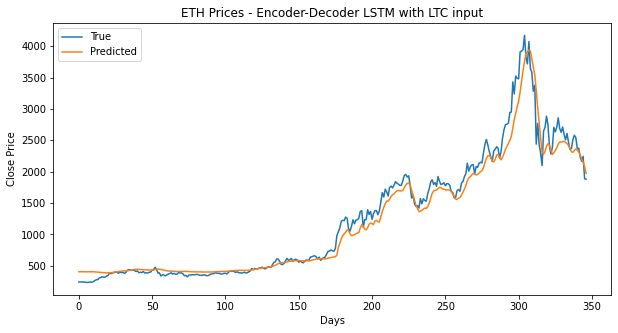


Testing Loss:  0.00425  ||  Testing RMSE:  0.0652  ||  Testing MAE:  0.0428

Training Number  1


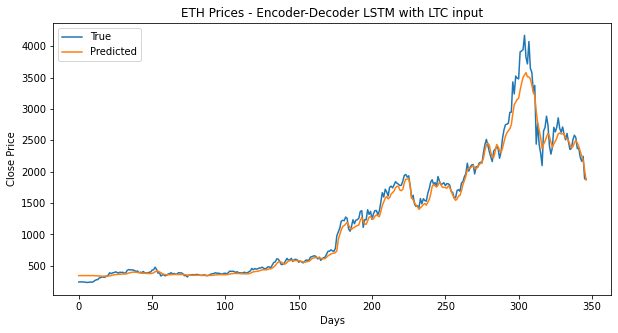


Testing Loss:  0.00374  ||  Testing RMSE:  0.0612  ||  Testing MAE:  0.0334

Training Number  2


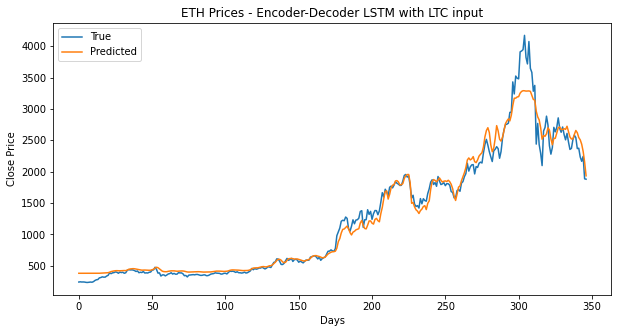


Testing Loss:  0.00355  ||  Testing RMSE:  0.0596  ||  Testing MAE:  0.0372

Training Number  3


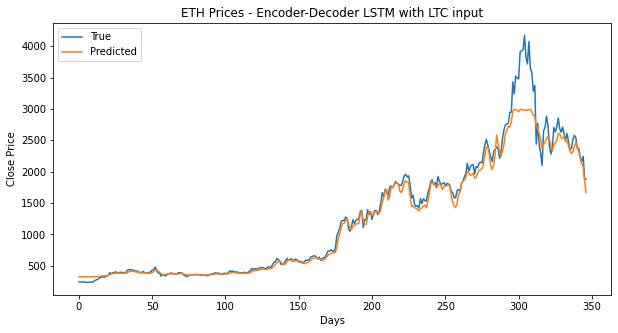


Testing Loss:  0.00478  ||  Testing RMSE:  0.0691  ||  Testing MAE:  0.0372

Training Number  4


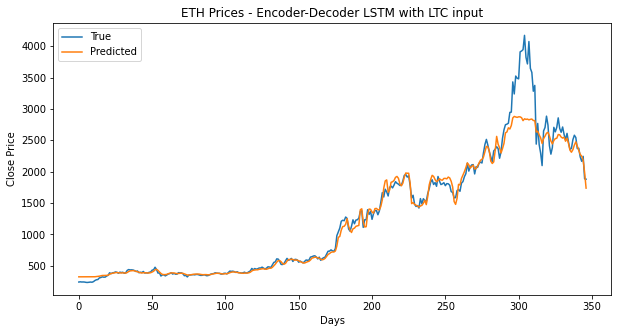


Testing Loss:  0.00508  ||  Testing RMSE:  0.0712  ||  Testing MAE:  0.037

Encoder-Decoder LSTM with BTC input -- 
Average Test Loss:  0.00428  ||  Average Test RMSE:  0.0653  ||  Average Test MAE:  0.0375


In [ ]:
newlosslist_b = []
newrmselist_b = []
newmaelist_b = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)

  # for encoder-decoder model, reshape output into [samples, timesteps, features]
  new_y_train_ed = ltc_y_train.reshape((ltc_y_train.shape[0], ltc_y_train.shape[1], 1))

  new_model_b.fit(ltc_X_train , new_y_train_ed , epochs=98, shuffle=False, verbose = 0)    # Best epoch from optimisation code notebook for this model was 98

  # generate the test predictions and plot them against the true values

  test_pred_new_b = new_model_b.predict(X_test)
  test_pred_new_b = test_pred_new_b.reshape((test_pred_new_b.shape[0], test_pred_new_b.shape[1]*test_pred_new_b.shape[2]))
  test_pred_new_b = yscaler.inverse_transform(test_pred_new_b)


  plt.figure(figsize = (10, 5))
  plt.plot(y_test_reshape_inv[:,0], label = 'True')
  plt.plot(test_pred_new_b[:,0], label = 'Predicted')
  plt.legend()
  plt.title("ETH Prices - Encoder-Decoder LSTM with LTC input")
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_new_b, test_rmse_new_b, test_mae_new_b = new_model_b.evaluate(X_test, y_test_ed, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_new_b), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_new_b), ' ||  Testing MAE: ', float('%.3g' % test_mae_new_b))

  newlosslist_b.append(test_loss_new_b)
  newrmselist_b.append(test_rmse_new_b)
  newmaelist_b.append(test_mae_new_b)

print('\nEncoder-Decoder LSTM with BTC input -- \nAverage Test Loss: ', float('%.3g' % np.mean(newlosslist_b)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(newrmselist_b)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(newmaelist_b)))

# **3. Model Building on CoLab for Bidirectional LSTM model (labelled in the code as Model C)**

#### I will now create a Bidirectional LSTM model with the same optimal parameters and architecture discovered from hypertuning. This model will be trained on the additional input data.


In [ ]:
new_model_c = Sequential()
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True), input_shape=(n_steps_in, n_features), merge_mode='sum'))
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True), merge_mode='sum'))
new_model_c.add(Dropout(0.3))
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True), merge_mode='sum'))
new_model_c.add(Dropout(0.3))
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu'), merge_mode='sum'))
new_model_c.add(Dropout(0.3))
new_model_c.add(Dense(n_steps_out))
new_model_c.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate= 0.001) , metrics=[rmse, mae])


In [ ]:
new_model_c.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 60)            31680     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 60)            58080     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 60)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14, 60)            58080     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 60)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60)                58080     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)               

#### Train the model with the optimal parameters using LTC data as input and test it 5 times to predict ETH close prices.




Training Number  0


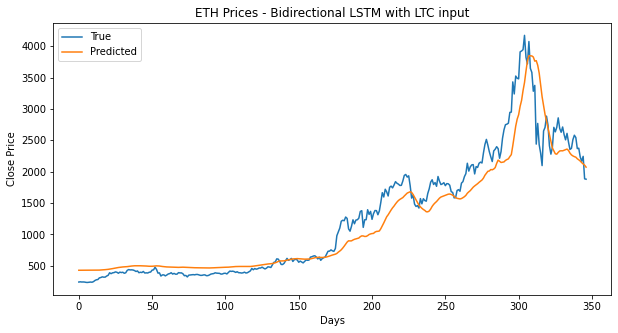


Testing Loss:  0.00848  ||  Testing RMSE:  0.0921  ||  Testing MAE:  0.0608

Training Number  1


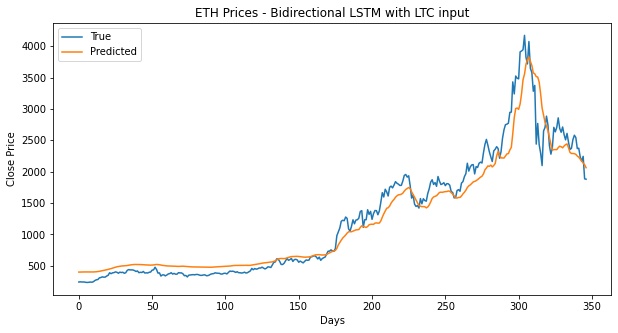


Testing Loss:  0.00613  ||  Testing RMSE:  0.0783  ||  Testing MAE:  0.0529

Training Number  2


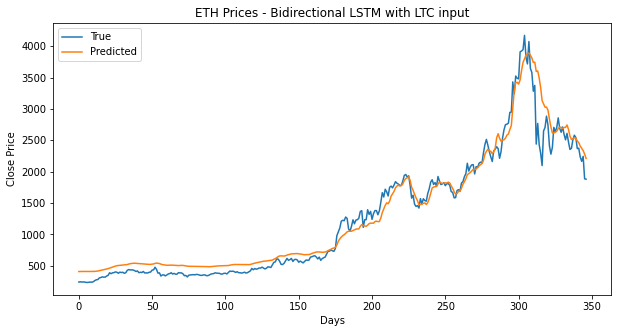


Testing Loss:  0.00434  ||  Testing RMSE:  0.0659  ||  Testing MAE:  0.0455

Training Number  3


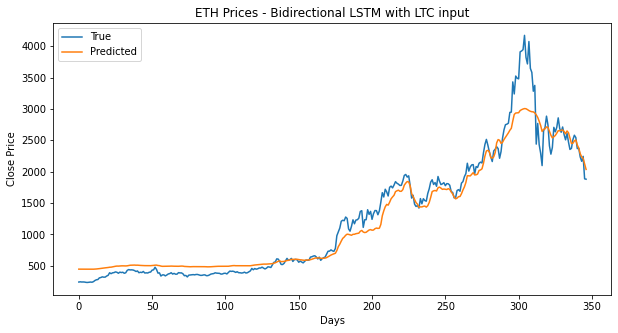


Testing Loss:  0.00553  ||  Testing RMSE:  0.0744  ||  Testing MAE:  0.0487

Training Number  4


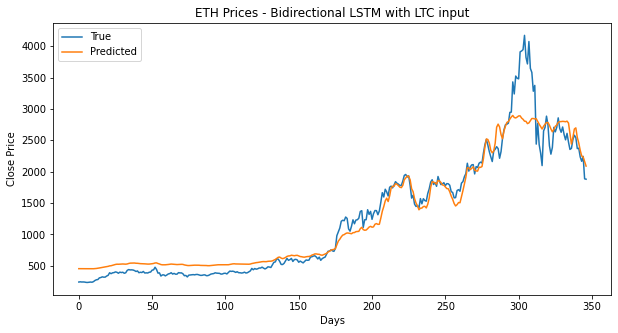


Testing Loss:  0.00489  ||  Testing RMSE:  0.07  ||  Testing MAE:  0.0479

Bidirectional LSTM with LTC input -- 
Average Test Loss:  0.00588  ||  Average Test RMSE:  0.0761  ||  Average Test MAE:  0.0512


In [ ]:
newlosslist_c = []
newrmselist_c = []
newmaelist_c = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  new_model_c.fit(ltc_X_train , ltc_y_train , epochs=67, shuffle=False, verbose = 0)   # Best epoch from optimisation code notebook for this model was 67

  # generate the test predictions and plot them against the true values

  test_pred_new_c = new_model_c.predict(X_test)
  test_pred_new_c = yscaler.inverse_transform(test_pred_new_c)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_inv[:,0], label = 'True')
  plt.plot(test_pred_new_c[:,0], label = 'Predicted')
  plt.legend()
  plt.title("ETH Prices - Bidirectional LSTM with LTC input")
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_new_c, test_rmse_new_c, test_mae_new_c = new_model_c.evaluate(X_test, y_test, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_new_c), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_new_c), ' ||  Testing MAE: ', float('%.3g' % test_mae_new_c))

  newlosslist_c.append(test_loss_new_c)
  newrmselist_c.append(test_rmse_new_c)
  newmaelist_c.append(test_mae_new_c)

print('\nBidirectional LSTM with LTC input -- \nAverage Test Loss: ', float('%.3g' % np.mean(newlosslist_c)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(newrmselist_c)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(newmaelist_c)))


# **Statistical comparison of results**
##### The dataset was determined to be non-parametric during the Exploratory Data Analysis stage. The models also have been trained on different training sets therefore I will be using a non-parametric, unpaired statistical hypothesis test to compare the performance of the baseline models with the models that have had additonal input.
##### I will be using the Mann-Whitney U Test from the SciPy Stats module on the RMSE scores for each of the models https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

*   If p <= 0.05 then the null hypothesis is rejected. There is a statistically significant difference between the performances of the models.
*   If p > 0.05 then we accept the null hypothesis that there is no significant difference between the two performances and any potential differences are by chance.



In [ ]:
# I need to read in the RMSE results from the baseline models.

# Baseline Multi-Step LSTM models (model A)
baseline_a = pd.read_csv('/content/drive/My Drive/Different Inputs/baselineScores_a.csv')
baseline_a = np.array(baseline_a)

# Baseline Encoder-Decoder LSTM models (model B)
baseline_b = pd.read_csv('/content/drive/My Drive/Different Inputs/baselineScores_b.csv')
baseline_b = np.array(baseline_b)

# Baseline Bidirectional LSTM models (model C)
baseline_c = pd.read_csv('/content/drive/My Drive/Different Inputs/baselineScores_c.csv')
baseline_c = np.array(baseline_c)

In [ ]:
# Multi-Step LSTM models (model A)
stat1, p1 = mannwhitneyu(baseline_a, newrmselist_a)
print('Multi-Step LSTM Models: p-value is ', float('%.3g' % p1))

# Encoder-Decoder LSTM models (model B)
stat2, p2 = mannwhitneyu(baseline_b, newrmselist_b)
print('Encoder-Decoder LSTM Models: p-value is ', float('%.3g' % p2))

# Bidirectional LSTM models (model C)
stat3, p3 = mannwhitneyu(baseline_c, newrmselist_c)
print('Bidirectional LSTM Models: p-value is ', float('%.3g' % p3))

Multi-Step LSTM Models: p-value is  0.222
Encoder-Decoder LSTM Models: p-value is  0.69
Bidirectional LSTM Models: p-value is  0.0317
